In [1]:
import gym

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import torch
from collections import namedtuple

from DDQN import DDQN
from DDPG import DDPG
from config import config
from off_policy import off_policy_train

## SETTING

In [2]:
#== CONFIGURATION ==
EVAL = False
print('='*4 + ' CONFIGURATION ' + '='*4)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)
CONFIG = config(RENDER=False, DOUBLE=True, BATCH_SIZE=64, SOFT_UPDATE=True)
for key, value in CONFIG.__dict__.items():
    if key[:1] != '_': 
        print(key, ': ', value)

==== CONFIGURATION ====
cpu
MAX_EPISODES :  200
MAX_EP_STEPS :  200
LR_A :  0.001
LR_A_END :  0.0001
LR_C :  0.001
LR_C_END :  0.0001
EPSILON :  0.9
EPSILON_END :  0.05
MEMORY_CAPACITY :  10000
BATCH_SIZE :  64
GAMMA :  0.9
TAU :  0.01
HARD_UPDATE :  200
SOFT_UPDATE :  True
RENDER :  False
ENV_NAME :  Pendulum-v0
MAX_MODEL :  5
DOUBLE :  True


### ENVIRONMENT

In [3]:
#== Pendulum ==
env = gym.make(CONFIG.ENV_NAME)
env.seed(1)
s_dim = env.observation_space.shape[0]
a_dim = env.action_space.shape[0]
print(s_dim, a_dim)

action_num = 5
action_list = np.linspace(-2, 2, num=action_num, endpoint=True).reshape(-1,1)
r_enhance = lambda r: (r + 8)/8 # reward \in [~-16, 0] -> shift to about [-1, 1]

running_reward = -1000
running_reward_th = -180

3 1


## DDQN

In [4]:
#== AGENT ==
agent=DDQN(s_dim, action_num, device, CONFIG, action_list)

#== TRAINING RECORD ==
TrainingRecord = namedtuple('TrainingRecord', ['ep', 'avg_reward', 'reward', 'loss_c'])
training_records = []

for ep in range(CONFIG.MAX_EPISODES):
    s = env.reset()
    ep_reward = 0.
    for step_num in range(CONFIG.MAX_EP_STEPS):
        print('\r {:d}'.format(step_num), end='')
        if CONFIG.RENDER:
            env.render()
        # action selection
        a, a_idx = agent.select_action(s)

        # interact with env
        s_, r, done, _ = env.step(a)
        ep_reward += r
        if done:
            s_ = None

        # Store the transition in memory
        agent.store_transition(s, a_idx, r_enhance(r), s_)
        s = s_

        # Perform one step of the optimization (on the target network)
        loss_c = agent.update()
        if done:
            break
    running_reward = running_reward * 0.9 + ep_reward * 0.1
    training_records.append(TrainingRecord(ep, running_reward, ep_reward, loss_c))

    if ep % 10 == 0:
        print('\rEp[{:3.0f}]: Running Reward: {:3.2f} \t Real Reward: {:.2f}'.format(ep, running_reward, ep_reward))
    if running_reward > running_reward_th:
        print("\rSolved! Running reward is now {:3.2f}!".format(running_reward))
        env.close()
        break

Ep[  0]: Running Reward: -1048.31 	 Real Reward: -1483.07
Ep[ 10]: Running Reward: -1219.61 	 Real Reward: -1039.91
Ep[ 20]: Running Reward: -978.96 	 Real Reward: -616.07
Ep[ 30]: Running Reward: -617.30 	 Real Reward: -129.78
Ep[ 40]: Running Reward: -344.82 	 Real Reward: -261.11
Ep[ 50]: Running Reward: -238.89 	 Real Reward: -261.22
Ep[ 60]: Running Reward: -188.67 	 Real Reward: -259.05
Ep[ 70]: Running Reward: -269.52 	 Real Reward: -131.87
Ep[ 80]: Running Reward: -257.33 	 Real Reward: -360.97
Ep[ 90]: Running Reward: -192.28 	 Real Reward: -244.42
Solved! Running reward is now -175.03!


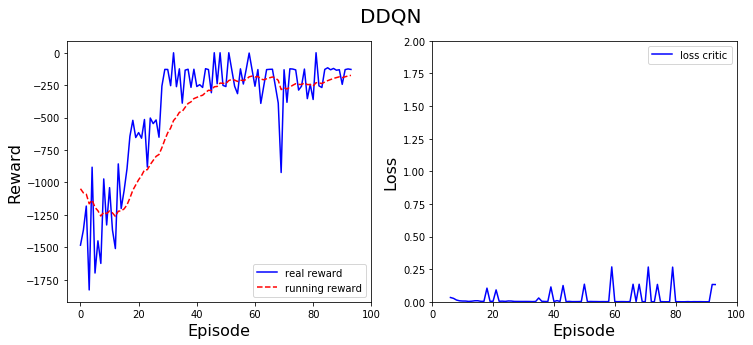

In [5]:
fig = plt.figure(figsize=(12,4.8))
fig.suptitle('DDQN', fontsize=20)

ax = fig.add_subplot(121)
ax.plot([r.ep for r in training_records], [r.reward for r in training_records], 'b-', label='real reward')
ax.plot([r.ep for r in training_records], [r.avg_reward for r in training_records], 'r--', label='running reward')
ax.set_xlabel('Episode', fontsize=16)
ax.set_xticks(np.arange(0, 120, 20))
ax.set_ylabel('Reward', fontsize=16)
ax.legend(loc=4)

ax = fig.add_subplot(122)
ax.plot([r.ep for r in training_records], [r.loss_c for r in training_records], 'b-', label='loss critic')
ax.legend()
ax.set_xticks(np.arange(0, 120, 20))
ax.set_ylim(0,2)
ax.set_xlabel('Episode', fontsize=16)
ax.set_ylabel('Loss', fontsize=16)
plt.savefig("../img/ddqn_pendulum_soft.png")
#plt.savefig("../img/dqn.png")
plt.show()

## DDPG

In [6]:
#== AGENT ==
agent=DDPG(s_dim, a_dim, device, CONFIG)

#== TRAINING RECORD ==
from collections import namedtuple
TrainingRecord = namedtuple('TrainingRecord', ['ep', 'avg_reward', 'reward', 'loss_a', 'loss_c'])
training_records = []
running_reward = -1000

for ep in range(CONFIG.MAX_EPISODES):
    s = env.reset()
    ep_reward = 0.
    for step_num in range(CONFIG.MAX_EP_STEPS):
        print('\r {:d}'.format(step_num), end='')
        if CONFIG.RENDER:
            env.render()
        # action selection
        a = agent.select_action(s) # output is in [-1, 1]
        a *= 2

        # interact with env
        s_, r, done, _ = env.step(np.array([a]))
        ep_reward += r
        if done:
            s_ = None

        # Store the transition in memory
        agent.store_transition(s, a, r_enhance(r), s_)
        s = s_

        # Perform one step of the optimization (on the target network)
        loss_a, loss_c = agent.update()
        if done:
            break
    running_reward = running_reward * 0.9 + ep_reward * 0.1
    training_records.append(TrainingRecord(ep, running_reward, ep_reward, loss_a, loss_c))

    if ep % 10 == 0:
        print('\rEp[{:3.0f}]: Running Reward: {:3.2f} \t Real Reward: {:.2f}'.format(ep, running_reward, ep_reward))
    if running_reward > running_reward_th:
        print("\rSolved! Running reward is now {:3.2f}!".format(running_reward))
        env.close()
        break

Ep[  0]: Running Reward: -1007.82 	 Real Reward: -1078.17
Ep[ 10]: Running Reward: -1218.07 	 Real Reward: -1204.31
Ep[ 20]: Running Reward: -699.37 	 Real Reward: -5.50
Ep[ 30]: Running Reward: -370.60 	 Real Reward: -125.38
Ep[ 40]: Running Reward: -231.64 	 Real Reward: -371.55
Ep[ 50]: Running Reward: -225.31 	 Real Reward: -124.21
Ep[ 60]: Running Reward: -233.65 	 Real Reward: -382.84
Ep[ 70]: Running Reward: -200.56 	 Real Reward: -129.42
Ep[ 80]: Running Reward: -189.38 	 Real Reward: -125.63
Solved! Running reward is now -178.23!


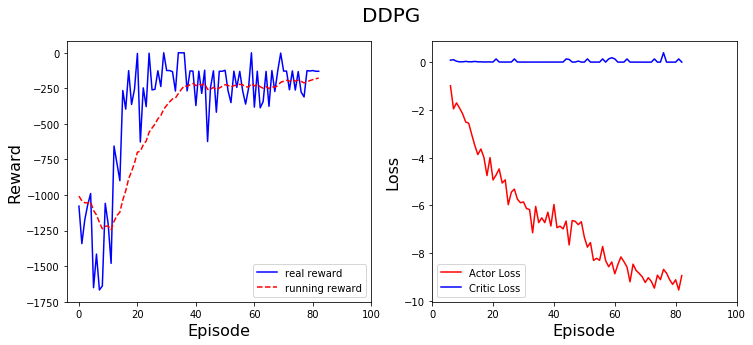

In [7]:
fig = plt.figure(figsize=(12,4.8))
fig.suptitle('DDPG', fontsize=20)

ax = fig.add_subplot(121)
ax.plot([r.ep for r in training_records], [r.reward for r in training_records], 'b-', label='real reward')
ax.plot([r.ep for r in training_records], [r.avg_reward for r in training_records], 'r--', label='running reward')
ax.set_xlabel('Episode', fontsize=16)
ax.set_xticks(np.arange(0, 120, 20))
ax.set_ylabel('Reward', fontsize=16)
ax.legend(loc=4)

ax = fig.add_subplot(122)
ax.plot([r.ep for r in training_records], [r.loss_a for r in training_records], 'r-', label='Actor Loss')
ax.plot([r.ep for r in training_records], [r.loss_c for r in training_records], 'b-', label='Critic Loss')
ax.legend()
ax.set_xlabel('Episode', fontsize=16)
ax.set_xticks(np.arange(0, 120, 20))
ax.set_ylabel('Loss', fontsize=16)
plt.savefig("../img/ddpg_pendulum_soft.png")
plt.show()

## Evaluation

In [8]:
if EVAL:
    s = env.reset()
    ep_reward = 0
    for i in range(1000):
        env.render()
        # action selection
        a, a_idx = agent.select_action(s)

        # interact with env
        s_, r, _, _ = env.step(a)
        ep_reward += r
        s = s_
    print(ep_reward)
    env.close()